<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/NN_bwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [2]:
%pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 4.8 MB/s eta 0:00:00


In [3]:
import torchmetrics
import torchvision

Loading and preprocessing the data

In [4]:
#Load the dataset
penguins = tfds.load('penguins', as_supervised=True, split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/penguins/processed/1.0.0.incompleteVG3NZF/penguins-train.tfrecord*...:   0…

Dataset penguins downloaded and prepared to /root/tensorflow_datasets/penguins/processed/1.0.0. Subsequent calls will reuse this data.


In [5]:
# By default, the Dataset object is an iterator over the elements.
# The instructions below extract the underlying tensors.
X, y = penguins.batch(500).get_single_element()
X, y = X.numpy(), y.numpy()

In [6]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

In [7]:
Xtrain = torch.from_numpy(Xtrain).float()
Xtest = torch.from_numpy(Xtest).float()

In [8]:
ytrain = torch.from_numpy(ytrain).long()
ytest = torch.from_numpy(ytest).long()

Define MultiLayer Neural Network

In [9]:
from torch import nn
from torch.nn import functional as F

In [10]:
class MNN(nn.Module):
  def __init__(self, input_size, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b):
    super().__init__()

    self.w1 = nn.Parameter(fc1w)
    self.b1 = nn.Parameter(fc1b)
    
    self.w2 = nn.Parameter(fc2w)
    self.b2 = nn.Parameter(fc2b)

    self.w3 = nn.Parameter(fc3w)
    self.b3 = nn.Parameter(fc3b)

  def forward(self, x):
    x = F.relu(x@self.w1 + self.b1)
    x = F.relu(x@self.w2 + self.b2)
    x = x@self.w3 + self.b3
    x = x.reshape(1, -1)

    return torch.softmax(x, 1)

In [11]:
# We check if CUDA is available. If you do not see it,
# activate a GPU from Runtime >> Change runtime type and 
# restart the notebook.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Initialize the parameters

In [12]:
# We initialize the parameters randomly with values in [-1, 1] and the model with an input size
fc1w = torch.FloatTensor(4, 64).uniform_(-1, 1)
fc1b = torch.FloatTensor(64).uniform_(-1, 1)
fc2w = torch.FloatTensor(64, 8).uniform_(-1, 1)
fc2b = torch.FloatTensor(8).uniform_(-1, 1)
fc3w = torch.FloatTensor(8, 3).uniform_(-1, 1)
fc3b = torch.FloatTensor(3).uniform_(-1, 1)
mnn = MNN(4, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b).to(device)

In [13]:
# Note: we also need to move data when asking for a prediction
print(mnn(Xtrain[0].to(device)))

tensor([[0.0255, 0.0031, 0.9713]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Calculate predictions

In [54]:
def pred(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, x):
  ypred=torch.randn((x.shape[0],3))
  for j in range (x.shape[0]):
    xj = x[j]
    xj = F.relu(xj@fc1w + fc1b)
    xj = F.relu(xj@fc2w + fc2b)
    xj = xj@fc3w + fc3b
    xj = xj.reshape(1, -1)
    ypred[j]=torch.softmax(xj, 1)
  return ypred

Define accuracy

In [55]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue).float().mean()

In [56]:
# Average accuracy at initialization is 10% (random guessing).
accuracy(ytrain.to(device), mnn(Xtrain.to(device)))

tensor(0., device='cuda:0')

Define Cross-Entropy

In [57]:
def cross_entropy(ytrue, ypred):
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [58]:
ypred = pred(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, Xtrain)
print(cross_entropy(ytrain, ypred))

tensor(0.5798, grad_fn=<NegBackward0>)


Train the network

In [59]:
import time 

In [82]:
def train_bwd_gradient(x, y):
  losses = []
  accuracies = []

  #Parameters
  fc1w = torch.FloatTensor(4, 64).uniform_(-1, 1).requires_grad_(True)
  fc1b = torch.FloatTensor(64).uniform_(-1, 1).requires_grad_(True)
  fc2w = torch.FloatTensor(64, 8).uniform_(-1, 1).requires_grad_(True)
  fc2b = torch.FloatTensor(8).uniform_(-1, 1).requires_grad_(True)
  fc3w = torch.FloatTensor(8, 3).uniform_(-1, 1).requires_grad_(True)
  fc3b = torch.FloatTensor(3).uniform_(-1, 1).requires_grad_(True)

  ypred = pred(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, x)
  loss = cross_entropy(y, ypred)

  #mnn = MNN(4, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b)

  t = 0
  t0 = time.time()
  while loss>0.2:

    #Compute the gradients
    loss.backward()

    with torch.no_grad():

      #Apply gradients
      fc1w -= 0.05*fc1w.grad
      fc1b -= 0.05*fc1b.grad
      fc2w -= 0.05*fc2w.grad
      fc2b -= 0.05*fc2b.grad
      fc3w -= 0.05*fc3w.grad
      fc3b -= 0.05*fc3b.grad

      # Gradients are accumulated: we need to zero them out before the next iteration
      fc1w.grad.zero_()
      fc1b.grad.zero_()
      fc2w.grad.zero_()
      fc2b.grad.zero_()
      fc3w.grad.zero_()
      fc3b.grad.zero_()

      losses.append(loss.detach().item())
      accuracies.append(accuracy(ytrain, ypred).item())

    t1=time.time()
    t+=t1-t0
    t0=t1
    print('Time', t, 'loss', loss)

    #Compute the predictions
    ypred = pred(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, x)

    #Compute the loss
    loss = cross_entropy(y, ypred)

  return fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, losses, accuracies

In [76]:
fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, losses, accuracies = train_bwd_gradient(Xtrain, ytrain)

Time 0.03893566131591797 loss tensor(3.3459, grad_fn=<NegBackward0>)
Time 0.09975600242614746 loss tensor(1.7212, grad_fn=<NegBackward0>)
Time 0.16115188598632812 loss tensor(1.3629, grad_fn=<NegBackward0>)
Time 0.2375810146331787 loss tensor(1.1385, grad_fn=<NegBackward0>)
Time 0.31513404846191406 loss tensor(1.0033, grad_fn=<NegBackward0>)
Time 0.3861582279205322 loss tensor(0.9259, grad_fn=<NegBackward0>)
Time 0.46346569061279297 loss tensor(0.8761, grad_fn=<NegBackward0>)
Time 0.5331196784973145 loss tensor(0.8373, grad_fn=<NegBackward0>)
Time 0.6082403659820557 loss tensor(0.8042, grad_fn=<NegBackward0>)
Time 0.675605297088623 loss tensor(0.7749, grad_fn=<NegBackward0>)
Time 0.7504315376281738 loss tensor(0.7485, grad_fn=<NegBackward0>)
Time 0.8214285373687744 loss tensor(0.7239, grad_fn=<NegBackward0>)
Time 0.8869874477386475 loss tensor(0.7010, grad_fn=<NegBackward0>)
Time 0.950829029083252 loss tensor(0.6794, grad_fn=<NegBackward0>)
Time 1.0164661407470703 loss tensor(0.6590, g

In [77]:
import matplotlib.pyplot as plt

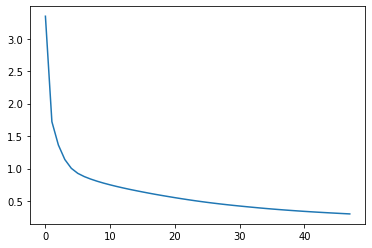

In [78]:
plt.plot(losses)

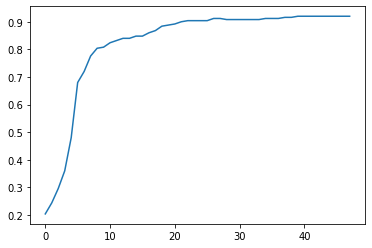

In [79]:
plt.plot(accuracies)

Evaluate the network

In [80]:
mnn = MNN(4, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b)
ypred=torch.randn(Xtest.size(0),3)
error=0
for i in range (Xtest.size(0)):
  ypred[i]=mnn(Xtest[i])
  if (mnn(Xtest[i]).argmax(1)- ytest[i])!=0:
    error = error+ 1
print('Error: ', error)

Error:  9


In [81]:
print(accuracy(ytest, ypred))

tensor(0.8929)
